In [7]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
import PIL
import glob
import scipy.io
from sklearn.model_selection import train_test_split

from vae import VAE, Sampling

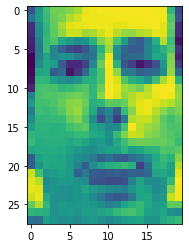

In [8]:
mat = scipy.io.loadmat('frey_rawface.mat')
data = mat['ff'].reshape(28,20,-1)
data = data.astype("float32") / 255.0
data = np.moveaxis(data, -1, 0)[..., np.newaxis]
plt.imshow(data[0])

In [9]:
batch_size = 16
train_dataset = (tf.data.Dataset.from_tensor_slices(data)
                 .shuffle(data.shape[0]).batch(batch_size))
# test_dataset = (tf.data.Dataset.from_tensor_slices(test_images)
#                 .shuffle(train_images.shape[0]).batch(batch_size))

In [16]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 20, 1))
x = layers.Conv2D(32, 3, activation="relu", padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dropout(.3)(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(28 * 20 * 64, activation="relu")(latent_inputs)
x = layers.Dropout(.3)(x)
x = layers.Reshape((28, 20, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=1, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=1, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 28, 20, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 28, 20, 32)   320         input_7[0][0]                    
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 28, 20, 64)   18496       conv2d_6[0][0]                   
__________________________________________________________________________________________________
flatten_3 (Flatten)             (None, 35840)        0           conv2d_7[0][0]                   
____________________________________________________________________________________________

In [17]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(),run_eagerly=True)
vae.fit(train_dataset, epochs=20,verbose=1)

Epoch 1/20
123/123 [==============================] - 6s 43ms/step - loss: 366.2713 - reconstruction_loss: 357.3014 - kl_loss: 0.1815
Epoch 2/20
123/123 [==============================] - 5s 41ms/step - loss: 351.3730 - reconstruction_loss: 349.5839 - kl_loss: 0.9944
Epoch 3/20
123/123 [==============================] - 5s 41ms/step - loss: 349.5426 - reconstruction_loss: 347.8743 - kl_loss: 1.5826
Epoch 4/20
123/123 [==============================] - 5s 41ms/step - loss: 349.3029 - reconstruction_loss: 347.4373 - kl_loss: 1.7423
Epoch 5/20
123/123 [==============================] - 5s 41ms/step - loss: 349.0023 - reconstruction_loss: 347.1219 - kl_loss: 1.8493
Epoch 6/20
123/123 [==============================] - 5s 41ms/step - loss: 348.8278 - reconstruction_loss: 346.7515 - kl_loss: 2.0145
Epoch 7/20
123/123 [==============================] - 5s 41ms/step - loss: 348.7686 - reconstruction_loss: 346.5151 - kl_loss: 2.0403
Epoch 8/20
123/123 [==============================] - 5s 41ms/

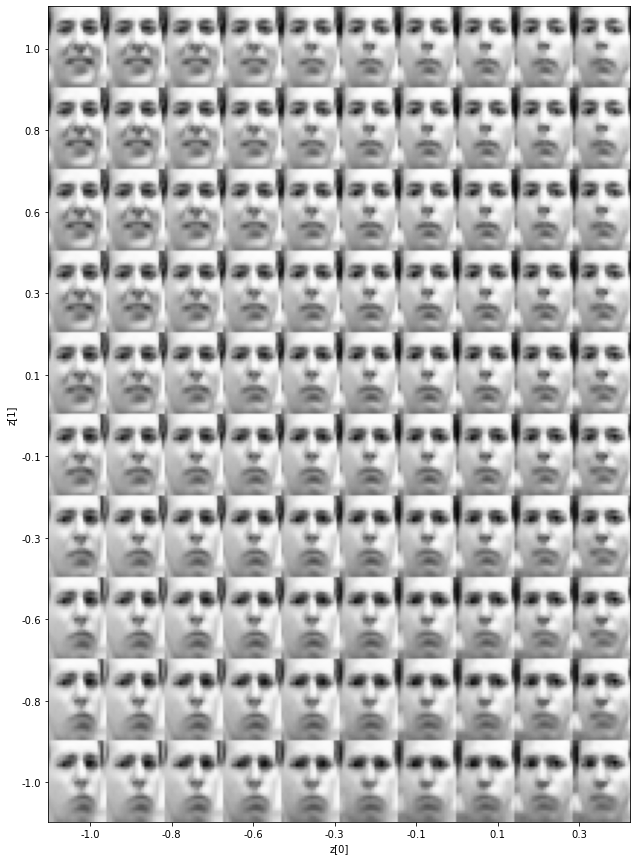

In [18]:
def plot_latent_space(vae, n=10, figsize=15):
    # display a n*n 2D manifold of digits
    scale = 1.0
    figure = np.zeros((28 * n, 20 * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(28, 20)
            figure[
                i * 28 : (i + 1) * 28,
                j * 20 : (j + 1) * 20,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = 28 // 2
    end_range = n * 28 + start_range
    pixel_range = np.arange(start_range, end_range, 28)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.savefig('manifold.png')
    plt.show()


plot_latent_space(vae)

In [19]:
vae.decoder.save('frey_decoder.h5')

In [ ]:
def make_gif_from_model(model,n=50):
    images = []
    scale = 1.0
    digit_size = 28
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            if j==i:
                images.append(digit)
    print(len(images))
    imageio.mimsave('manifold.gif', images)
make_gif_from_model(vae)